# Рынок заведений общественного питания в Москве

Цель проекта - определить, насколько целесообразно открытие в Москве небольшого кафе, в котором посетителей должны обслуживать роботы. Для ответа на этот вопрос предполагается изучение текущего положения дел на рынке: наиболее популярных видов объектов, основных сетей и распределения предприятий по районам и улицам города.

## Содержание <a id=contents></a>

1. [Загрузка и предобработка данных](#start)
2. [Анализ разных видов объектов](#objects)
3. [Анализ сетевых заведений](#networks)
4. [Изучение распределения заведений по районам города](#districts)
 - [Выделение сведений об улицах и районах из данных](#streets)
 - [Сравнение разных районов](#compare)
5. [Общий вывод](#conclusion)

## 1. Загрузка и предобработка данных <a id='start'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import requests

from io import BytesIO
from matplotlib import pyplot as plt
from collections import Counter
from warnings import filterwarnings

filterwarnings('ignore')
plt.style.use('seaborn')

In [2]:
df = pd.read_csv(r'rest_data.csv')

In [3]:
df

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
f'Число полных дубликатов: {df.duplicated().sum()}'

'Число полных дубликатов: 0'

Если мы исходим из того, что данные вбивались "руками", то, во-первых, не стоит доверять написанию названий: скорее всего прописные и строчные буквы там расставлены кое-как, поэтому названия можно привести к одному нижнему регистру. Далее можно попробовать выявить какой-то ключ, кроме id, по которому можно искать дубликаты. Пожалуй, таковым могло бы быть сочетание названия и адреса: сомнительно, чтобы одна компания открыла в одном и том же дома два заведения. Вместимость нам не подходит, если ее оценивали "на глаз" (интересно, как можно "на глаз" оценить 48 мест?). Есть проблемы и с типом объекта.

In [6]:
df['object_name'] = df['object_name'].str.lower()

In [7]:
Counter(df[df['object_name'] == 'kfc']['object_type'])

Counter({'ресторан': 30, 'предприятие быстрого обслуживания': 99, 'кафе': 26})

In [8]:
df[df['object_name'] == 'kfc'].sort_values('number', ascending=False).head(10)

,id,object_name,chain,object_type,address,number
3546,26073,kfc,да,предприятие быстрого обслуживания,"город Москва, 1-я Тверская-Ямская улица, дом 2...",400
2818,83589,kfc,да,предприятие быстрого обслуживания,"город Москва, Новослободская улица, дом 11, ст...",217
10207,170811,kfc,да,ресторан,"город Москва, шоссе Энтузиастов, дом 20",190
5937,69801,kfc,да,предприятие быстрого обслуживания,"город Москва, Авиамоторная улица, дом 41Б",190
1101,156704,kfc,да,ресторан,"город Москва, Страстной бульвар, дом 4, строен...",160
2093,148469,kfc,да,ресторан,"город Москва, Большая Серпуховская улица, дом ...",138
13465,195178,kfc,да,предприятие быстрого обслуживания,"город Москва, Дмитровское шоссе, дом 13, корпус 1",120
12078,177203,kfc,да,предприятие быстрого обслуживания,"город Москва, Большая Семёновская улица, дом 16",120
5988,154378,kfc,да,предприятие быстрого обслуживания,"город Москва, Шоссейная улица, дом 2, корпус 3",118
15224,207911,kfc,да,предприятие быстрого обслуживания,"город Москва, Верхняя Радищевская улица, дом 22",115


По этой выборке видно, что с типом объектов все сложно: разные заведения KFC (выбрано в качестве примера - большая и известная сеть примерно одинаковых заведений) относятся к кафе, ресторанам или фастфудам. Возможно, у нас есть какой-то критерий их разделения: например, в фастфуды записывается что-то вроде заведений в фудкортах, а кафе и рестораны делятся еще по какому-то признаку (размеру?), но по топ-10 KFC я затрудняюсь однозначно его выделить, тут надо глубже знать специфику ресторанного бизнеса. Здесь следует обратиться за пояснениями к составителю базы или к заказчику исследования (какие критерии его интересуют?) и предложить записать хотя бы крупнейшие сети в одну категорию, если нет резонов этого не делать. Это бы, подозреваю, заметно увеличило долю фастфудов в сетевых заведениях.  
В общем, при таких неясностях с типом объектов я не думаю, что их стоит включать в потенциальный ключ - лучше искать дубликаты по двум колонкам - адрес и название.

In [9]:
df[df.duplicated(subset=['object_name', 'address'])]

,id,object_name,chain,object_type,address,number
114,28613,комбинат питания мгту им.н.э.баумана,нет,закусочная,"город Москва, Бригадирский переулок, дом 3-5",216
115,28614,комбинат питания мгту им.н.э.баумана,нет,буфет,"город Москва, Бригадирский переулок, дом 3-5",12
579,149227,общественное питание,нет,столовая,"город Москва, Павелецкая площадь, дом 1",70
580,149205,общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",35
581,149131,общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",39
...,...,...,...,...,...,...
15217,214146,макдоналдс,да,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",0
15241,210885,kfc,да,предприятие быстрого обслуживания,"город Москва, Манежная площадь, дом 1, строение 2",41
15253,214872,чайхона №1,да,кафе,"город Москва, Кутузовский проспект, дом 57",0
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20


Уже по этому списку видно, что у нас есть разные виды дубликатов по парам 'название-адрес'. В первых пяти случаях мы можем предполагать, что речь идет о разных заведениях: комбинат питания ВУЗа может содержать несколько столовых/буфетов в одном корпусе (во всяком случае в моем университете в каждом здании их было несколько), равным образом, несколько столовых может быть на Павелецком вокзале (то есть по адресу Павелецкая площадь, 1). Однако в случае заведений с id 149205 и 149131 можно предполагать, что речь идет об одном и том же - оценка вместимости очень близка. В целом я бы поостерегся удалять дубликаты с названиями вроде 'Общественное питание', потому что неясно, что так описано (опять же без дополнительных консультаций).  
Не менее интересная ситуация и с другими парами. Возьмем несколько первых пар 'название-адрес'.

In [10]:
dup_pairs = pd.Series(df[df.duplicated(subset=['object_name', 'address'])]
                      .groupby(['object_name', 'address']).groups)
print(f'Всего пар: {len(dup_pairs)}\n')
dup_pairs.head()

Всего пар: 153



chips         город Москва, улица Кузнецкий Мост, дом 7                   Int64Index([10755], dtype='int64')
eat and talk  город Москва, улица Воздвиженка, дом 4/7, строение 2         Int64Index([8005], dtype='int64')
fresh bar     город Москва, Комсомольская площадь, дом 6, сооружение 1    Int64Index([11662], dtype='int64')
il patio      город Москва, Манежная площадь, дом 1, строение 2            Int64Index([6372], dtype='int64')
kfc           город Москва, Большая Семёновская улица, дом 16             Int64Index([12078], dtype='int64')
dtype: object

Посмотрим подробнее на заведения из двух первых пар (они выбраны не из каких-то особенных соображений, просто случайно).

In [11]:
df[np.logical_or(
    np.logical_and(df['object_name'] == 'chips', 
                  df['address'] == 'город Москва, улица Кузнецкий Мост, дом 7'),
    np.logical_and(df['object_name'] == 'eat and talk', 
                  df['address'] == 'город Москва, улица Воздвиженка, дом 4/7, строение 2')
)].sort_values('object_name')

,id,object_name,chain,object_type,address,number
2802,67936,chips,нет,кафе,"город Москва, улица Кузнецкий Мост, дом 7",190
10755,178813,chips,нет,бар,"город Москва, улица Кузнецкий Мост, дом 7",90
8004,153873,eat and talk,нет,ресторан,"город Москва, улица Воздвиженка, дом 4/7, стро...",80
8005,154087,eat and talk,нет,ресторан,"город Москва, улица Воздвиженка, дом 4/7, стро...",10


В обеих парах заметна подозрительная разница во вместимости: даже при оценке на глаз она едва ли отличалась в два раза и в восемь раз.  
Об 'Eat&Talk' я могу судить на основании личного опыта: кафе там одно ([их сайт](https://eattalk.ru/) подтверждает мои наблюдения) и его вместимость ближе к 80, чем к 10 (не знаю, откуда взялась меньшая цифра).  
О 'Chips' я [нашел](https://www.gdebar.ru/bars/tagansko-krasnopresnenskaya/kuzneckij-most/chips) такие сведения: в нем 'несколько форматов объединили под одной крышей', причем ресторан и лаунж (что бы это ни было) в сумме вмещают 108 человек, веранда - 200 человек. Эти данные неплохо соотносятся с тем, что мы видим в таблице: вероятно, 'ресторан и лаунж' были определены как 'бар', а 'веранда' - как 'кафе' (это к вопросу о том, насколько релевантно указание типов в нашей таблице).  
Какой вывод из этого можно сделать? Неполные дубликаты в нашей таблице возникают по разным причинам: где-то у нас в одном месте, действительно, два заведения с одинаковым названием, где-то одно оказывается поделено на два, где-то дубликаты наводят на мысль об ошибочных данных. Основательная обработка таких дубликатов в принципе возможна (рассмотреть по одной все 153 пары 'адрес-название' вполне реально), но заняла бы слишком много времени, даже если эту задачу в определенной мере оптимизировать (с ходу приходит в голову автоматически считать дубликатами те пары, в которых разница во вместимости не превышает какого-то порога, например, 25% - это погрешность оценки на глаз). Либо дубликаты можно просто удалить, т.к. их доля в таблице не превышает 2%, так что это не должно сильно сказаться на результатах.

In [12]:
df = df.drop_duplicates(subset=['object_name', 'address'])

Однако, к сожалению, проблема этим не исчерпывается. Выше мы выбрали в качестве ключа пару 'название-адрес', но кто сказал, что названия у нас записаны единообразно? Посмотрим на уникальные названия (напомню, мы их привели к нижнему регистру), причем ограничимся сетями.

In [13]:
obj_list = list(df[df['chain'] == 'да']['object_name'].unique())

In [14]:
print(len(obj_list))
obj_list

576


['пиццетория',
 'брусника',
 'алло пицца',
 'суши wok',
 'тануки',
 "домино'с пицца",
 'готика',
 'му-му',
 'хлеб насущный',
 'tajj mahal',
 'данкин донатс',
 'вареничная №1',
 'шоколадница',
 'теремок',
 'хинкальная',
 'шантимель',
 'хинкальная city',
 'кружка',
 'суши вок',
 'примавера',
 'виктория',
 'пиццерия «академия»',
 'чебуречная ссср',
 'макдоналдс',
 'grand cru',
 'чайхона №1',
 'панчо пицца',
 'kfc',
 'сабвей',
 'ресторан «якитория»',
 'советские времена',
 'кафе «андерсон»',
 'кафе «subway»',
 'ресторан «макдоналдс»',
 'суши сет',
 'шоколад',
 'тирольские пироги',
 'гамбринус',
 'пицца фабрика',
 'subway',
 'кафе «якитория»',
 'кафе «тануки»',
 'сити пицца',
 'кофе хаус',
 'кулинарная лавка братьев караваевых братья караваевы',
 'прайм',
 'пицца экспресс',
 'шоколадница кофе хаус',
 'николай',
 'якитория',
 'магнолия',
 'кофе с собой',
 'джаганнат',
 'волконский',
 'moskalyan',
 'гино-но-таки',
 'тратория semplice',
 'ньокки',
 'хижина',
 'додо пицца',
 'крошка картошка',


Даже по беглому просмотру этого списка видно, что названия многих сетевых заведений написаны вразнобой (см., например, последние 'мяты'). Это ставит под сомнение нашу методику поиска дубликатов: возможно, мы не выловили дубликаты из-за различий в написании названий. Эта проблема делает затруднительным и анализ отдельных сетей, если бы он нам понадобился, - не вполне понятно, как их выделять по названиям. В определенной мере могли бы помочь лемматизация и выделение ключевых слов, однако с ними тоже не все просто. Вот пример.

In [15]:
for name in obj_list:
    result = re.search('.*хинкальная.*', name)
    if result:
        print(result.group(0)) 

хинкальная
хинкальная city
цинандали хинкальная
хинкальная №1
мимино хинкальная
хинкальная кинто
кафе «хинкальная»
ресторан хинкальная
m cafe хинкальная
marrakesh хинкальная
грузинская кухня эzо хинкальная


Как видно, лемма 'хинкальная' относилась бы сразу к нескольким сетям (причем среди них есть и та, которая называется 'Хинкальная', поэтому считать это просто типом нельзя).  
Таким образом, разбор названий даже после уменьшения регистра и лемматизации требовал бы значительных усилий. Конечно, некоторые сети было бы выделить несложно, например, ту же KFC. К счатью, от нас не требуется подробно сравнивать отдельные сети. При иной постановке задачи я бы попытался либо уточнить, какие именно сети могут нас интересовать, на основе консультаций с коллегами и списка вроде [такого](https://moscow-restaurants.ru/restaurants/chain.html) и выделял их с помощью лемматизации и регулярных выражений, предполагая, какие части названий могут считаться _conditio sine qua non_.

In [16]:
df.object_type.unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

В таблице нет повторов и пропусков, сведения о каждом объекте включают id, название, тип, принадлежность к сети, адрес и количество посадочных мест. Для удобства дальнейшей работы изменим тип данных в столбце `id` на `sting`, а в столбце `chain` заменим значения на 0 (нет) и 1 (да). Кроме того, мы заменим значения 'предприятие быстрого обслуживания' и 'магазин (отдел кулинарии)' в столбце `object_type` на 'фастфуд' и 'кулинария', т.к. впоследствии (в частности при построении графиков) нам будет удобно опрерировать словами примерно одинаковой длины.

In [17]:
df['id'] = df['id'].astype('str')

In [18]:
df['chain'] = df['chain'].apply(lambda x: 1 if x == 'да' else 0)

In [19]:
df = df.replace({'предприятие быстрого обслуживания': 'фастфуд',
                     'магазин (отдел кулинарии)': 'кулинария'}) # для более гармоничной легедны графика

In [20]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,0,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,0,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,0,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,1,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,0,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15141 entries, 0 to 15364
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15141 non-null  object
 1   object_name  15141 non-null  object
 2   chain        15141 non-null  int64 
 3   object_type  15141 non-null  object
 4   address      15141 non-null  object
 5   number       15141 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 828.0+ KB


Замены произведены.

#### Вывод
1. В таблице содержатся сведения о 15366 объектах общественного питания, для каждого указаны название, тип (один из девяти), адрес, вместимость, а также то, является ли объект сетевым.
2. В таблице нет пропусков и полных дубликатов, предобработка потребовала изменения некоторых значений на более удобные в дальнейшей работе.
3. В таблице имеется некоторое количество (около 1.5% данных) неполных дубликатов разной природы, детальный анализ которых требует много усилий и привлечения значительного объема сторонних данных, поэтому, а также в силу их малочисленности решено их удалить.
4. Вероятно, в таблице остались и другие неполные дубликаты, связанные с разным написанием названий при заполнении данных вручную, их поиск (равно как и выделение отдельных сетей, если этого потребуют дальнейшие исследования) представляется весьма трудозатратной задачей, а их число едва ли велико.

[Наверх](#contents)

## 2. Анализ разных видов объектов <a id='objects'>

Для получения первичного представления о состоянии рынка исследуем число объектов разного типа и число посадочных мест в них, а также долю сетевых заведений.

In [22]:
object_count = df.groupby('object_type')\
                .agg({'id': 'count'})\
                .reset_index()\
                .sort_values('id', ascending=False)
object_count

,object_type,id
3,кафе,5991
7,столовая,2572
6,ресторан,2271
8,фастфуд,1885
0,бар,849
1,буфет,565
4,кафетерий,392
2,закусочная,344
5,кулинария,272


In [23]:
# объединим четыре последние строки в категорию 'другие' для построения графика
objects_plot = object_count[:-4]
others = pd.DataFrame({'object_type': ['другие'],
                       'id': [object_count['id'][-4:].sum()]                      
                      })
objects_plot = pd.concat([objects_plot, others])

In [24]:
def pie_plot(x, legend, title):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.pie(x, 
           autopct='%1.1f%%',
           explode=[0.01 for i in range(len(x))],
           textprops={'fontsize':'12'},
           pctdistance = 1.1
          )
    plt.title(title, fontsize=20)
    plt.legend(legend, loc="best", fancybox=True, fontsize=12);

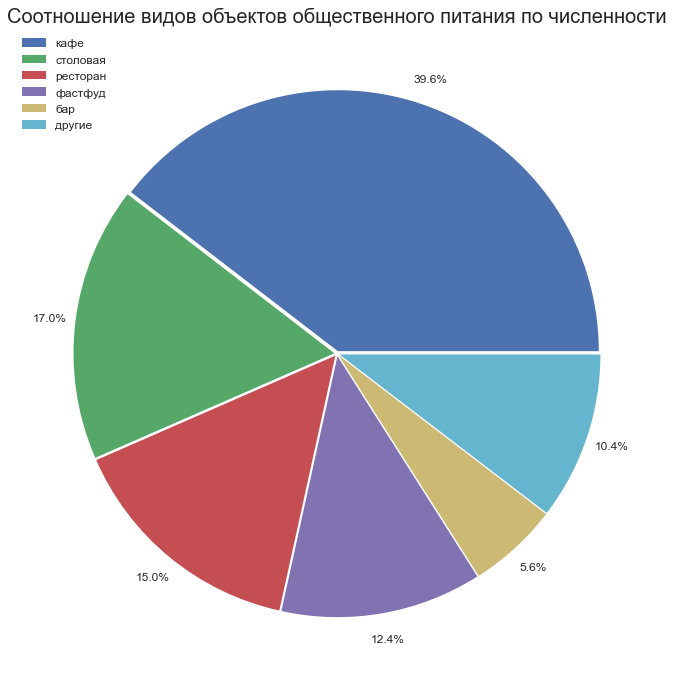

In [25]:
pie_plot(objects_plot['id'], objects_plot['object_type'], 'Соотношение видов объектов общественного питания по численности')

Как видно, больше всего (почти 40%) в Москве объектов типа "кафе", кроме того, большое количество заведений - это столовые (17%), рестораны (15%), фастфуды (12.5%) и бары (5.6%). Для уточнения картины взглянем на число посадочных мест в заведениях разного типа.

In [26]:
df['number'].describe()

count    15141.000000
mean        59.976091
std         75.040146
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

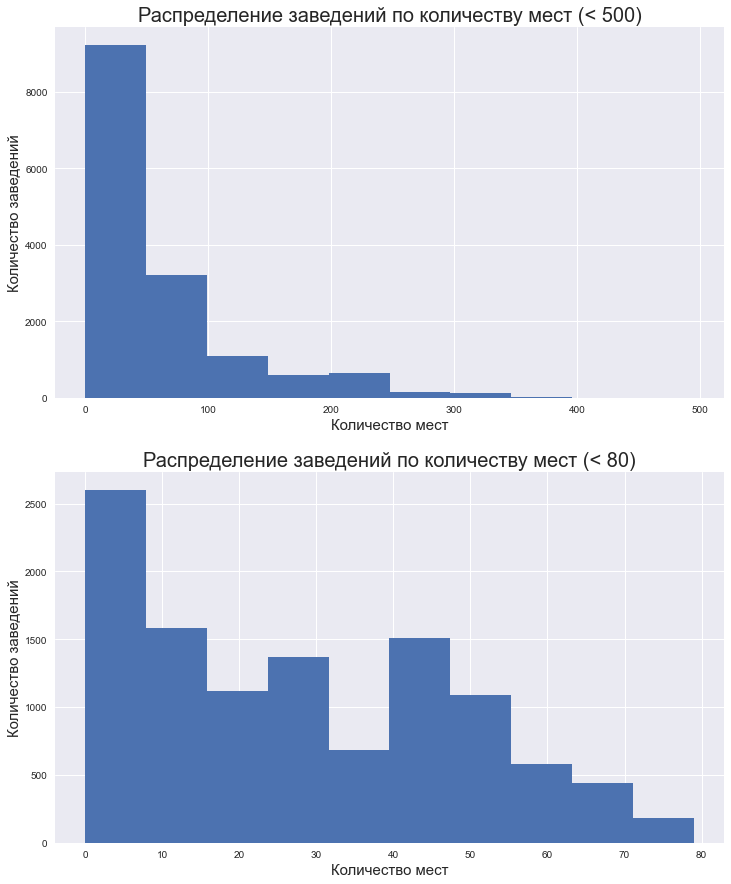

In [27]:
fig, ax = plt.subplots(2,1, figsize=(12,15))
fig.set_size_inches((12,15))
ax[0].hist(df[df['number'] < 500]['number'])
ax[0].set_title('Распределение заведений по количеству мест (< 500)', fontsize=20)
ax[1].hist(df[df['number'] < 80]['number'])
ax[1].set_title('Распределение заведений по количеству мест (< 80)', fontsize=20)
for ax in ax.flat:
    ax.set_xlabel('Количество мест', fontsize=15)
    ax.set_ylabel('Количество заведений', fontsize=15);

В целом медианное число мест в московских заведениях - 40. При этом наблюдается очень сильный разброс значений: при том, что 75% заведений имеют не больше 80 мест, есть и очень большие значения. Среди относительно небольших заведений большая часть - совсем маленькие, менее десяти мест. В целом чем больше мест, тем меньше таких заведений, однако наблюдается локальный пик в районе 40 мест (вероятно, это "небольшие из больших" заведений). Посмотрим, как распределяется число мест в разных категориях. Сначала посмотри на самые большие заведения, которые  

In [28]:
print('Самые большие заведения:')
df[df['number'] > 400]

Самые большие заведения:


,id,object_name,chain,object_type,address,number
105,24616,сказка востока,0,ресторан,"город Москва, Коктебельская улица, дом 11, стр...",420
120,26075,макдоналдс,1,фастфуд,"город Москва, Большая Бронная улица, дом 29",580
1620,23767,кафе «кружка»,1,кафе,"город Москва, Чертановская улица, дом 1В, корп...",428
1916,138663,вьет соул,0,ресторан,"город Москва, Ярославское шоссе, дом 146, корп...",450
2057,140790,paulaner brauhaus,0,ресторан,"город Москва, Шлюзовая набережная, дом 2/1, ст...",500
2294,26988,ресторан «михаил светлов»,0,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",542
2301,23862,ресторан «вега»,0,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",424
2313,26560,ресторан «альфа»,0,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",1040
2317,73306,ресторан «бета»,0,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",660
2389,20906,комбинат питания мгуиэ,0,столовая,"город Москва, Старая Басманная улица, дом 21/4...",500


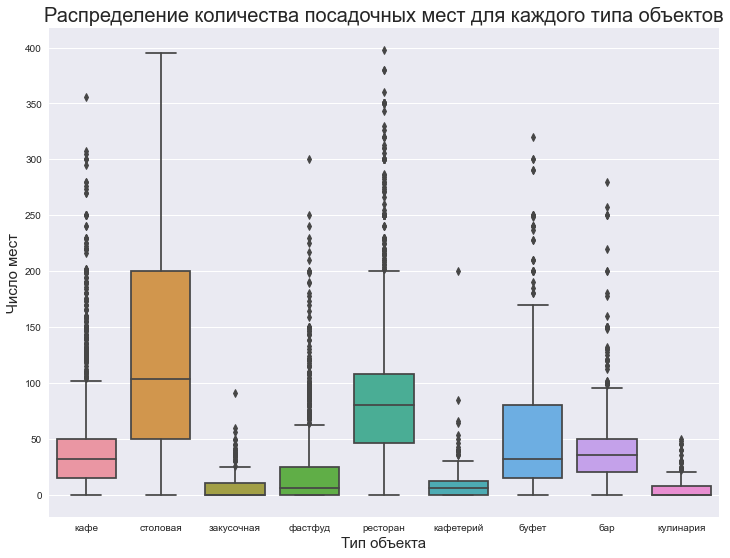

In [29]:
plt.figure(figsize=(12,9))
sns.boxplot(x='object_type', y='number', data=df[df['number'] < 400])
plt.title('Распределение количества посадочных мест для каждого типа объектов', fontsize=20)
plt.xlabel('Тип объекта', fontsize=15)
plt.ylabel('Число мест', fontsize=15);

Как видно, количество средних мест сильно зависит от типа заведения. В среднем самые большие - столовые, за ними следуют рестораны, кафе, буфеты и бары (то есть все интересующие нас категории). В остальных заведениях среднее число посадочных мест гораздо меньше. Интересно, что во всех категориях есть достаточно многочисленные выбросы, а самые большие заведения в основном относятся к ресторанам (большие банкетные залы, рестораны при гостиницах) и столовым, хотя наибольшее число мест имеет бар (ночной клуб, судя по его сайту). Для большей наглядности представим на графике медианное число посетителей по типам заведений.

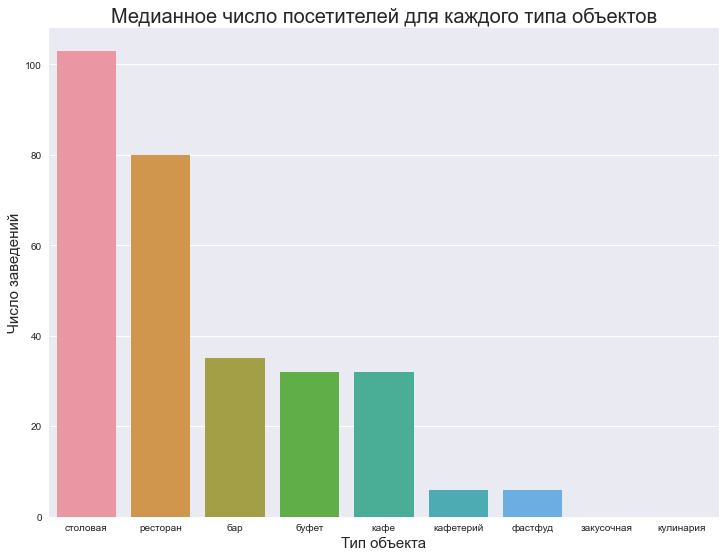

In [30]:
median_seats = df.groupby('object_type')\
                .agg({'number': 'median'})\
                .reset_index()\
                .sort_values('number', ascending=False)

plt.figure(figsize=(12,9))
sns.barplot(x='object_type', y='number', data=median_seats)
plt.title('Медианное число посетителей для каждого типа объектов', fontsize=20)
plt.xlabel('Тип объекта', fontsize=15)
plt.ylabel('Число заведений', fontsize=15);

In [31]:
df[df['object_type'] == 'ресторан']

,id,object_name,chain,object_type,address,number
18,58565,тануки,1,ресторан,"город Москва, Большая Академическая улица, дом 65",160
30,24387,готика,1,ресторан,"город Москва, Ангарская улица, дом 39",65
36,127979,месопотамия,0,ресторан,"город Москва, улица Арбат, дом 4, строение 1",50
39,88194,tajj mahal,1,ресторан,"город Москва, улица Арбат, дом 6/2",100
46,24967,il pizzaiolo,0,ресторан,"город Москва, улица Арбат, дом 31",70
...,...,...,...,...,...,...
15242,207425,kfc,1,ресторан,"город Москва, Ленинградский проспект, дом 62А",50
15255,218284,marmalato,1,ресторан,"город Москва, Хорошёвское шоссе, дом 27",0
15342,210776,мята lounge,1,ресторан,"город Москва, город Московский, улица Хабарова...",50
15351,223036,якитория,1,ресторан,"город Москва, Авиационная улица, дом 66",92


Медианное число мест в столовых - больше 100, в ресторанах - 80, в барах, буфетах, кафе - в пределеах 30-40 (к этой категории относится и наше заведение). Сложно оценить, как соотносится наше заведение с категорией 'ресторан'. Она достаточно разнообразная, в нее отнесены, как видно по десяти записям выше, даже некоторые предприятия фастфуда (KFC). Скорее всего, небольшие рестораны вроде 'Якитории' могут считаться нашими конкурентами, тогда как большие банкетные залы, о которых речь шла выше, занимают другой сегмент рынка. 

[Наверх](#contents)

## 3. Анализ сетевых заведений <a id='networks'></a>

Важная особенность рынка общественного питания - большое количество сетевых заведений, относящихся к разным категориям, распространенных по всему городу и т.д. Нам неизбежно придется столкнуться с ними, поэтому следует подробнее рассмотреть этот сегмент рынка. 

In [32]:
chain_share = df.groupby('chain').agg('count').reset_index().sort_values('id')
chain_share

,chain,id,object_name,object_type,address,number
1,1,2937,2937,2937,2937,2937
0,0,12204,12204,12204,12204,12204


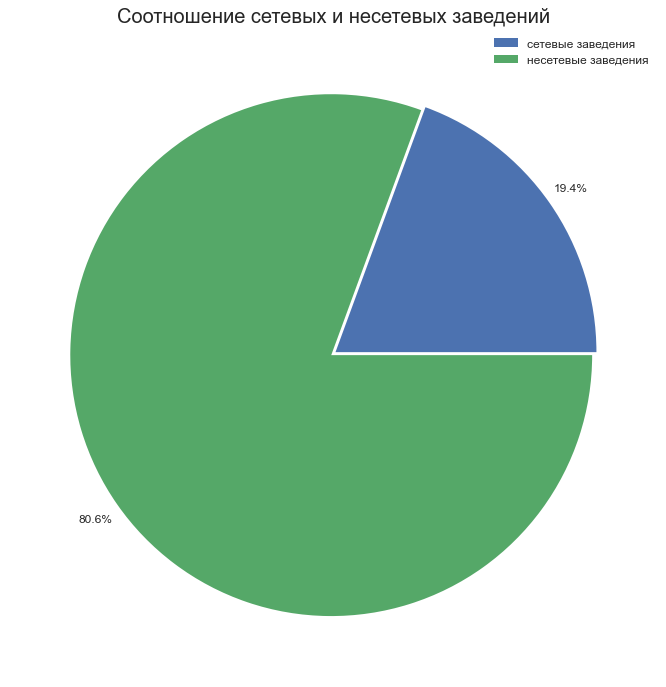

In [33]:
pie_plot(chain_share['id'], ['сетевые заведения', 'несетевые заведения'], 'Соотношение сетевых и несетевых заведений')

Доля сетевых заведений в Москве составляет 19.3%, то есть почти каждое пятое предприятие общественного питания относится к сетям. Для того, чтобы понять, какие именно заведения относятся к сетям, рассмотрим их типы и вместимость.

In [34]:
chains_type = df[df['chain'] == 1].groupby('object_type')['id'].agg('count').reset_index().sort_values('id', ascending=False)
chains_type

,object_type,id
3,кафе,1382
8,фастфуд,782
6,ресторан,539
5,кулинария,78
2,закусочная,56
4,кафетерий,51
0,бар,37
1,буфет,9
7,столовая,3


In [35]:
# объединим последние строки в категорию 'другие' для построения графика
chains_type_plot = chains_type[:3]
others = pd.DataFrame({'object_type': ['другие'],
                       'id': [chains_type['id'][3:].sum()]                      
                      })
chains_type_plot = pd.concat([chains_type_plot, others])

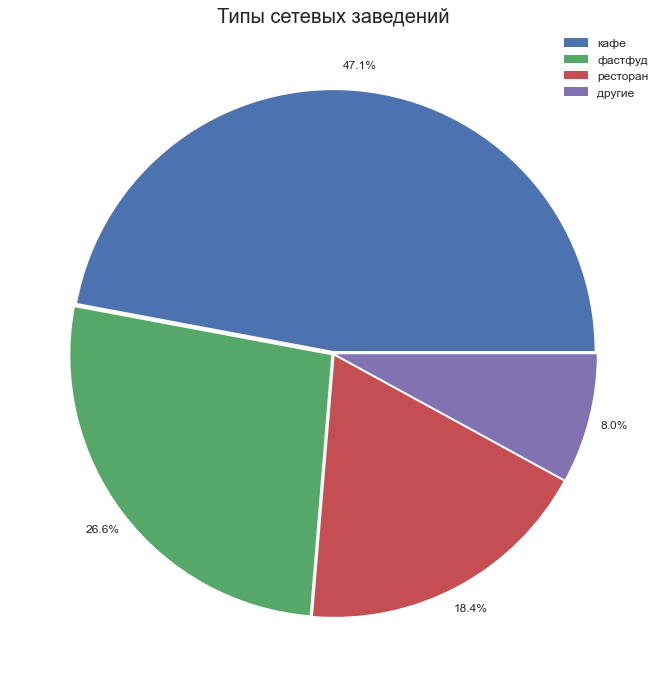

In [36]:
pie_plot(chains_type_plot['id'], chains_type_plot['object_type'], 'Типы сетевых заведений')

Большая часть (почти половина) сетевых заведений - это кафе. Большие доли составляют также фастфуды и рестораны (что предсказуемо, особенно учитывая размытость последней категории в нашей классификации).

Сравним число и долю сетевых и нескетевых предприятий каждого типа.

In [37]:
types_chain = pd.merge(df[df['chain'] == 1].groupby('object_type', as_index=False).agg({'id':'count'}),
                      df[df['chain'] == 0].groupby('object_type', as_index=False).agg({'id':'count'}),
                      on='object_type').rename(columns={'id_x': 'chain_cnt', 'id_y': 'non_chain_cnt'})
types_chain['chain_share'] = types_chain['chain_cnt'] / (types_chain['chain_cnt'] 
                                                               + types_chain['non_chain_cnt'])
types_chain.sort_values('chain_share', ascending=False)

,object_type,chain_cnt,non_chain_cnt,chain_share
8,фастфуд,782,1103,0.414854
5,кулинария,78,194,0.286765
6,ресторан,539,1732,0.237340
3,кафе,1382,4609,0.230679
2,закусочная,56,288,0.162791
4,кафетерий,51,341,0.130102
0,бар,37,812,0.043581
1,буфет,9,556,0.015929
7,столовая,3,2569,0.001166


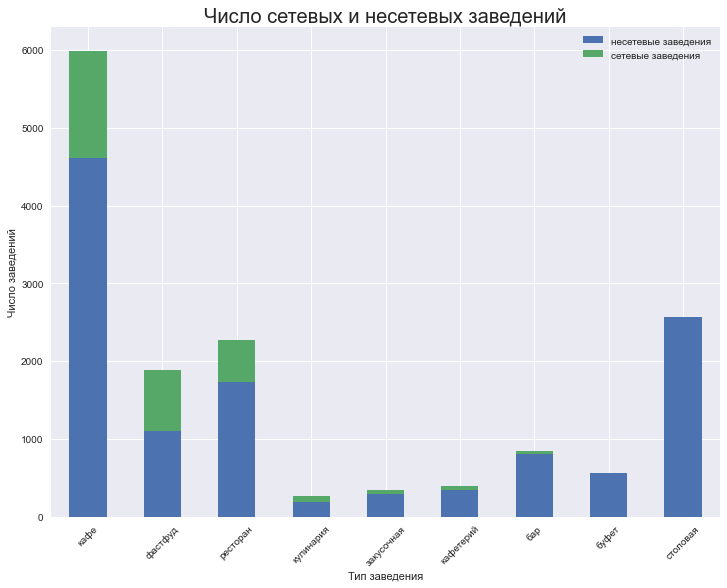

In [38]:
types_chain.sort_values('chain_cnt', ascending=False).\
            set_index('object_type')[['non_chain_cnt', 'chain_cnt']].plot(kind='bar', 
                                                                          stacked=True,
                                                                          figsize=(12,9)
                                                                         )
plt.xticks(rotation=45)
plt.title('Число сетевых и несетевых заведений', fontsize=20)
plt.xlabel('Тип заведения')
plt.ylabel('Число заведений')
plt.legend(['несетевые заведения', 'сетевые заведения']);

График абсолютной численности не очень хорош, поскольку из-за очень большого числа кафе нам плохо видны соотношения менее популярных типов, поэтому построим относительный график.

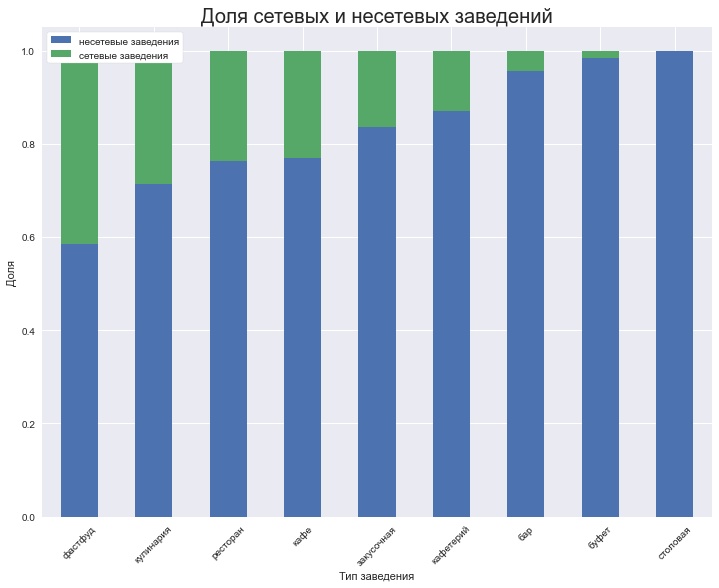

In [39]:
types_chain['non_chain_share'] = 1 - types_chain['chain_share']

types_chain.set_index('object_type')[['non_chain_share', 'chain_share']]\
            .sort_values('chain_share', ascending=False)\
            .plot(kind='bar', 
                    stacked=True,
                    figsize=(12,9)
                  )
plt.xticks(rotation=45)
plt.title('Доля сетевых и несетевых заведений', fontsize=20)
plt.xlabel('Тип заведения')
plt.ylabel('Доля')
plt.legend(['несетевые заведения', 'сетевые заведения'], frameon=True, facecolor='white', framealpha=1);

Итак, наибольшая доля сетевых заведений - среди фастфудов (41%), затем следуют кулинарии (28%) и кафе и рестораны с примерно одинаковой долей в 23-24%. Сетевых столовых и буфетов практически нет. Теперь оценим вместимость сетевых заведений разного типа.

In [40]:
df[df['chain'] == 1]['number'].describe()

count    2937.000000
mean       53.071502
std        57.256013
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
max       580.000000
Name: number, dtype: float64

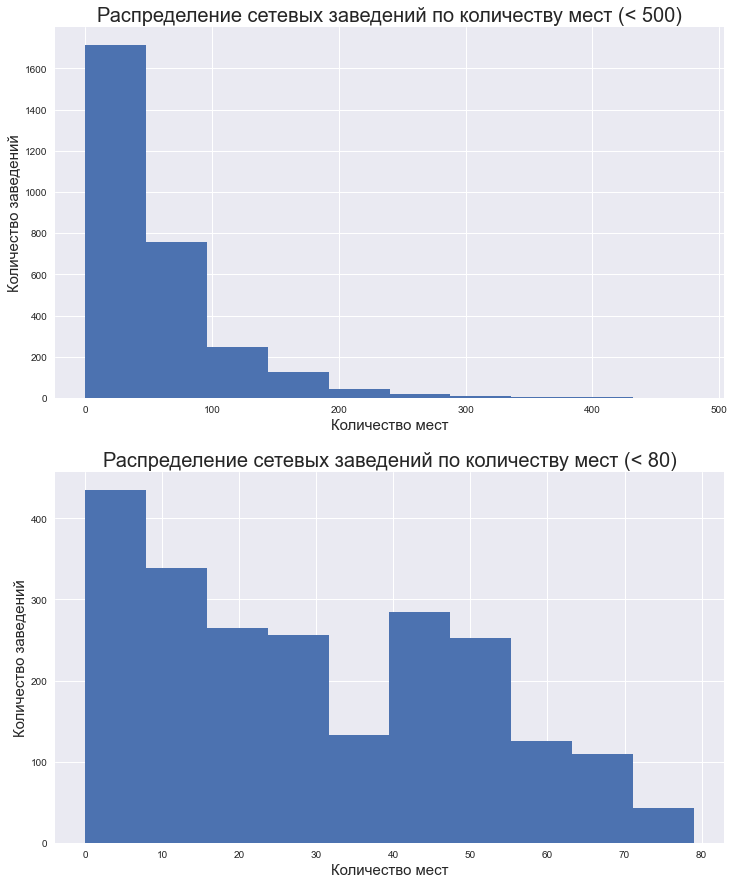

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(12,15))
ax[0].hist(df[np.logical_and(df['number'] < 500, df['chain'] == 1)]['number'])
ax[0].set_title('Распределение сетевых заведений по количеству мест (< 500)', fontsize=20)
ax[1].hist(df[np.logical_and(df['number'] < 80, df['chain'] == 1)]['number'])
ax[1].set_title('Распределение сетевых заведений по количеству мест (< 80)', fontsize=20)
for ax in ax.flat:
    ax.set_xlabel('Количество мест', fontsize=15)
    ax.set_ylabel('Количество заведений', fontsize=15);

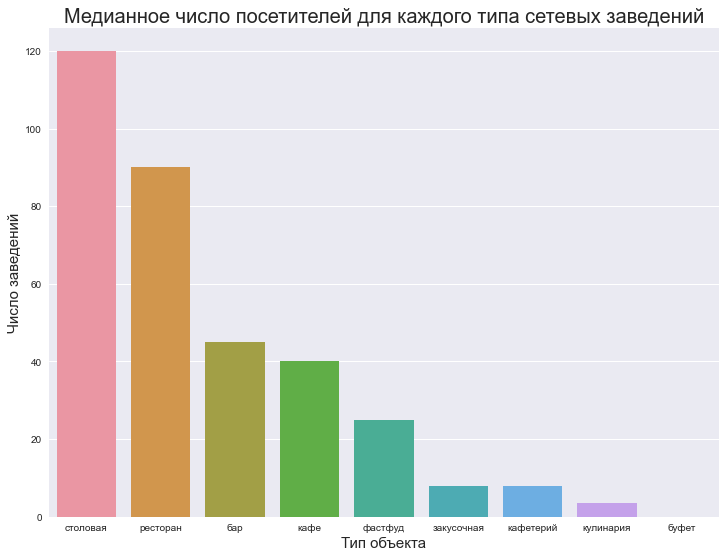

In [42]:
median_chain_seats = df[df['chain'] == 1].groupby('object_type')\
                .agg({'number': 'median'})\
                .reset_index()\
                .sort_values('number', ascending=False)

plt.figure(figsize=(12,9))
sns.barplot(x='object_type', y='number', data=median_chain_seats)
plt.title('Медианное число посетителей для каждого типа сетевых заведений', fontsize=20)
plt.xlabel('Тип объекта', fontsize=15)
plt.ylabel('Число заведений', fontsize=15);

В целом распределение мест в сетевых заведениях напоминает общую картину по всем предприятиям: большая часть заведений вмещают меньше 100 человек (75% заведений - меньше 75), много мелких заведений (от нуля до 30 мест), а также наблюдается 'локальный пик' в районе 40-50 мест. Самые большие предприятия - столовые, затем рестораны. Сетевые бары и кафе имеют примерно одинаковый медианный размер - около 40 мест. 

[Наверх](#contents)

## 4. Изучение распределения заведений по районам города <a id='districts'></a>

### Выделение сведений об улицах и районах из данных <a id='streets'></a>

Еще один фактор, который следует учесть, - расположение кафе. Изучим, как распределяются заведения по районам. Для выделения улицы из адреса воспользуемся регулярными выражениями. Сначала определим самые частые типы улиц в наших данных (улица, переулок и т.п.).

In [43]:
# делим адрес на отдельные слова
address_splited = df['address'].apply(lambda x: re.split(' |, ', x))

In [44]:
# считаем самые частые слова в адресах, из них выберем типы улиц
Counter(np.sum(address_splited)).most_common(30)

[('город', 15471),
 ('Москва', 15070),
 ('дом', 14632),
 ('улица', 8966),
 ('строение', 4070),
 ('1', 3973),
 ('корпус', 2732),
 ('2', 1979),
 ('проспект', 1423),
 ('шоссе', 1305),
 ('3', 1044),
 ('4', 823),
 ('проезд', 774),
 ('бульвар', 737),
 ('переулок', 722),
 ('5', 677),
 ('6', 547),
 ('Большая', 504),
 ('8', 489),
 ('7', 482),
 ('10', 462),
 ('12', 423),
 ('поселение', 415),
 ('9', 392),
 ('набережная', 382),
 ('площадь', 372),
 ('11', 338),
 ('15', 305),
 ('13', 296),
 ('владение', 295)]

Самые распространенные типы улиц - 'улица', 'проспект', 'шоссе', 'проезд', 'бульвар', 'переулок', 'набережная', 'площадь'. С учетом этого выделим улицу с помощью регулярного выражения, более редкие названия добавим по ходу дела, смотря по тому, что мы не учли.

In [45]:
df

,id,object_name,chain,object_type,address,number
0,151635,сметана,0,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,0,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,0,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,1,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,0,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15359,222077,кофейня «шоколадница»,1,кафе,"город Москва, Кантемировская улица, дом 47",72
15360,219759,шоколадница,1,кафе,"город Москва, улица Вавилова, дом 3",36
15361,208537,шоколадница,1,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,шоколадница,1,кафе,"город Москва, улица Земляной Вал, дом 33",10


In [46]:
expr = '([\w\s\d\-]*(улица|проспект|шоссе|проезд|бульвар|переулок|набережная|площадь|тупик|аллея|линия|квартал|микрорайон|километр|МКАД|территория|просек)[\w\s\d\-№\"]*),'
df['street'] = df['address'].str.extract(expr)[0]
df['street'] = df['street'].str.strip()

In [47]:
df

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,0,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,0,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,0,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,1,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе «вишневая метель»,0,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15359,222077,кофейня «шоколадница»,1,кафе,"город Москва, Кантемировская улица, дом 47",72,Кантемировская улица
15360,219759,шоколадница,1,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова
15361,208537,шоколадница,1,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,шоколадница,1,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал


In [48]:
df[df['street'].isnull()]

,id,object_name,chain,object_type,address,number,street
1405,20199,это,0,кафе,"город Москва, город Зеленоград, корпус 401",35,NaN
1406,68113,френдс,0,кафе,"город Москва, город Зеленоград, корпус 435",34,NaN
1407,20105,кафе «граф монте-кристо»,0,кафе,"город Москва, город Зеленоград, корпус 436",40,NaN
1408,22982,альфорно,0,кафе,"город Москва, город Зеленоград, корпус 438",49,NaN
1410,150537,кафе «вечный зов»,0,кафе,"город Москва, город Зеленоград, корпус 834А",30,NaN
...,...,...,...,...,...,...,...
14997,216942,шашлычный дворик,0,кафе,"город Москва, поселение Десеновское, деревня В...",15,NaN
14998,216926,кафе «сахли»,0,закусочная,"город Москва, поселение Десеновское, деревня В...",10,NaN
15015,208239,газпромнефть,0,кафе,"поселение ""Мосрентген"", деревня Дудкино, владе...",20,NaN
15137,209920,дюшес,1,ресторан,"город Москва, город Зеленоград, Проезд № 4806,...",100,NaN


После добавления того, что не было учтено изначально, мы получили очень громозкое регулярное выражение, но выделили улицы для всех адресов, кроме тех, которые фактически находятся в пригородных населенных пунктах (хотя и относящихся административно к Москве) и Зеленограде, где нет названий улиц. Теперь добавим сведения о районах, для этого воспользуемся базой адресов, которые предоставляет компания 'Мосгаз' ([файл](http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv) сохранен на Google.Drive).

In [49]:
spreadsheet_id = '1EvEymK1NGA5TIl8DDdE8NvLQQskB_PDwN7j8oU8nsh4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
districts = pd.read_csv(BytesIO(r.content))

In [50]:
districts.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [51]:
districts[districts['streetname'] == 'Профсоюзная улица']

,streetname,areaid,okrug,area
3845,Профсоюзная улица,123,ЮЗАО,Академический район
3867,Профсоюзная улица,132,ЮЗАО,Район Черемушки
3916,Профсоюзная улица,134,ЮЗАО,Район Ясенево
3948,Профсоюзная улица,126,ЮЗАО,Район Коньково
3996,Профсоюзная улица,129,ЮЗАО,Обручевский район
4024,Профсоюзная улица,131,ЮЗАО,Район Теплый Стан


Сведения об улицах выделены, сведения о районах добавлены, теперь можно проанализировать число заведений в разных районах.

### Сравнение разных районов <a id='compare'></a>

#### Улицы с наибольшем числом заведений

In [52]:
top_streets = df.groupby('street').agg({'id': 'nunique'}).reset_index().sort_values('id', ascending=False).head(10)
top_net_streets = df[df['chain'] == 1].groupby('street').agg({'id': 'nunique'}).reset_index().sort_values('id', ascending=False).head(10)

In [53]:
top_streets

,street,id
1456,проспект Мира,196
1040,Профсоюзная улица,180
712,Ленинградский проспект,171
1024,Пресненская набережная,165
425,Варшавское шоссе,163
715,Ленинский проспект,148
1452,проспект Вернадского,126
702,Кутузовский проспект,112
625,Каширское шоссе,110
632,Кировоградская улица,106


In [54]:
top_net_streets

,street,id
206,Ленинградский проспект,56
476,проспект Мира,53
317,Профсоюзная улица,51
108,Варшавское шоссе,42
170,Кировоградская улица,38
474,проспект Вернадского,38
134,Дмитровское шоссе,34
208,Ленинский проспект,30
541,улица Земляной Вал,29
494,улица Арбат,29


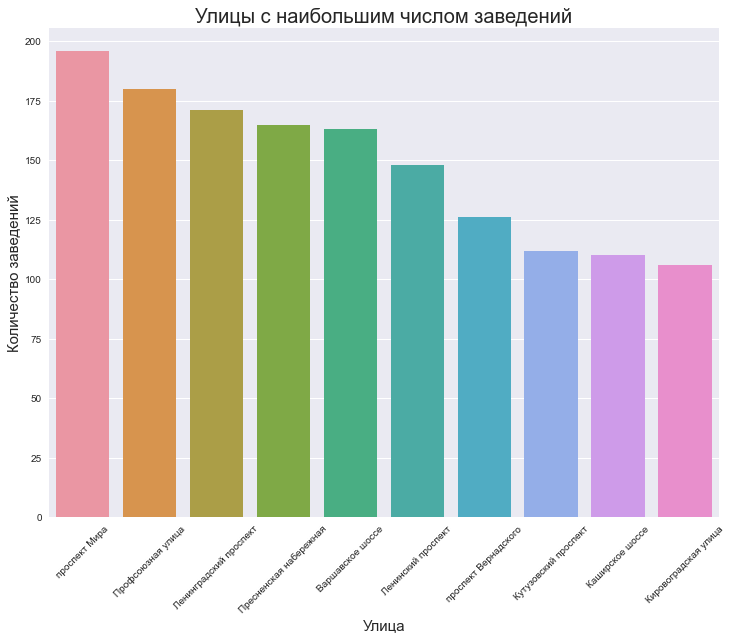

In [55]:
plt.figure(figsize=(12,9))
sns.barplot(x='street', y='id', data=top_streets)
plt.title('Улицы с наибольшим числом заведений', fontsize=20)
plt.xlabel('Улица', fontsize=15)
plt.ylabel('Количество заведений', fontsize=15)
plt.xticks(rotation=45);

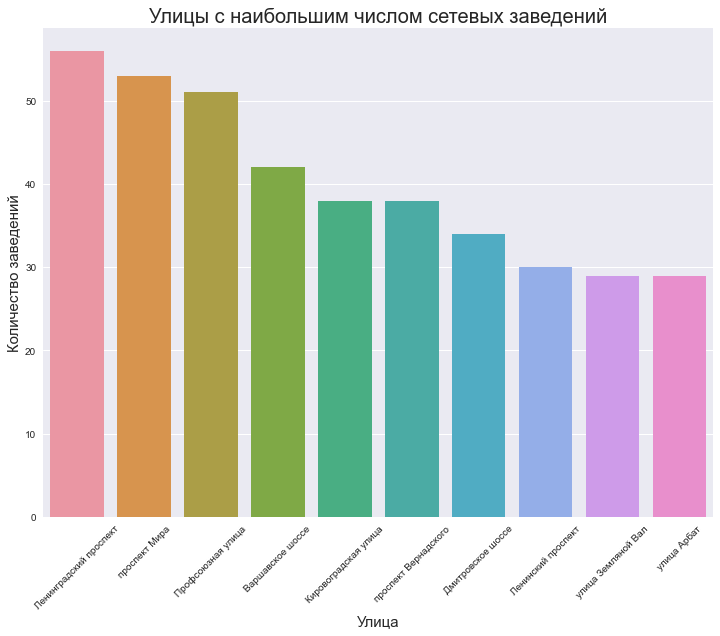

In [56]:
plt.figure(figsize=(12,9))
sns.barplot(x='street', y='id', data=top_net_streets)
plt.title('Улицы с наибольшим числом сетевых заведений', fontsize=20)
plt.xlabel('Улица', fontsize=15)
plt.ylabel('Количество заведений', fontsize=15)
plt.xticks(rotation=45);

В топе оказались в основном достаточно длинные улицы: проспект Мира, Профсоюзная, Ленинградский проспект и т.д. Они же входят и в топ улиц по числу сетевых заведений (рейтинги в значительной мере совпадают), однако в немна последних местах оказались также относительно короткие улицы в центре - Земляной Вал (вероятно, в значительной мере из-за ТЦ 'Атриум' и Курского вокзала) и Арбат (пешеходная туристическая улица в центре). Интересно, что в топ улиц по общему числу заведений попала Пресненская набережная - очень короткая улица, проходящая мимо Москва-Сити. Это несколько больших зданий с большим числом разных предприятий, однако это очень дорогой район, поэтому число сетевых заведений тут невелико. Определим, в каких районах они находятся.

In [57]:
top_10_distr = top_streets.merge(districts, how='left', left_on='street', right_on='streetname')[['street', 'area']]\
            .groupby('street')
for street in top_10_distr.groups:
    print(f'{street}:\n', ', '.join(top_10_distr.get_group(street)['area'].values), '\n')

Варшавское шоссе:
 Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное Бутово, Район Южное Бутово 

Каширское шоссе:
 Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное 

Кировоградская улица:
 Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное 

Кутузовский проспект:
 Район Дорогомилово, Район Фили-Давыдково 

Ленинградский проспект:
 Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол 

Ленинский проспект:
 Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан, Район Якиманка 

Пресненская набережная:
 Пресненский район 

Профсоюзная улица:
 Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан 

проспект Вернадского:
 Район Проспект Вернадского, 

По этому списку мы видим, что большая часть улиц проходит по нескольким районам (что в целом очевидно, т.к. они достаточно длинные), при этом можно выделить несколько 'регионов' Москвы, где они сосредоточены: юг (Нагатино, Чертаново и т.д.), юго-запад (Проспект Вернадского, Академический, Гагаринский и т.д.). Кроме них, улицы с большим числом заведений находятся в Дорогомилово (и примыкающем к нему Пресненском районе), а также на севере - проспект Мира и Ленинградский проспект (при этом они проходят по разным районам).

Для оценки того, какие предприятия чаще всего встречаются на 'популярных' улицах, оценим распределение числа посадочных мест на них.

In [58]:
top_places = df[df['street'].isin(top_streets['street'])]

In [59]:
top_places.head()

,id,object_name,chain,object_type,address,number,street
151,155973,кафе «андерсон»,1,кафе,"город Москва, Варшавское шоссе, дом 2",150,Варшавское шоссе
152,23618,кафе «subway»,1,кафе,"город Москва, Варшавское шоссе, дом 7, корпус 1",36,Варшавское шоссе
153,155852,кафе «ламаджо»,0,кафе,"город Москва, Варшавское шоссе, дом 29",30,Варшавское шоссе
154,152556,шаурма в пите,0,фастфуд,"город Москва, Варшавское шоссе, дом 72, корпус 2",0,Варшавское шоссе
155,120658,выпечка,0,кафетерий,"город Москва, Варшавское шоссе, дом 100",2,Варшавское шоссе


In [60]:
top_places['number'].describe()

count    1477.000000
mean       58.554502
std        90.619431
min         0.000000
25%        12.000000
50%        40.000000
75%        75.000000
max      1700.000000
Name: number, dtype: float64

In [61]:
top_places[top_places['number'] > 400]

,id,object_name,chain,object_type,address,number,street
4110,29320,столовая,0,столовая,"город Москва, Каширское шоссе, дом 31",680,Каширское шоссе
4480,27024,рум сервис,0,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",1200,Кутузовский проспект
6441,22856,ресторан «цдт»,0,ресторан,"город Москва, Ленинский проспект, дом 146",495,Ленинский проспект
7104,27033,банкетный,0,ресторан,"город Москва, Ленинградский проспект, дом 31А,...",625,Ленинградский проспект
7603,28149,сапфир 1,0,столовая,"город Москва, Варшавское шоссе, дом 127",500,Варшавское шоссе
9064,19719,комбинат питания «управление академсервис»,0,столовая,"город Москва, проспект Вернадского, дом 84, ст...",1288,проспект Вернадского
9327,167290,ресторан фреш сити,0,ресторан,"город Москва, Пресненская набережная, дом 8, с...",478,Пресненская набережная
12723,199696,arena by soho family,0,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700,Кутузовский проспект


In [62]:
mean_num_top = top_places.groupby('street', as_index=False)\
                        .agg({'number': 'median'})\
                        .sort_values('number', ascending=False)

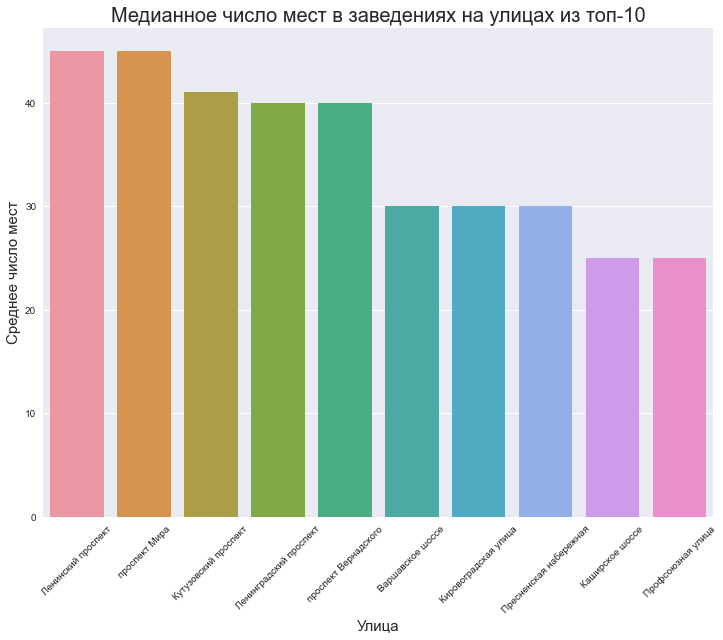

In [63]:
plt.figure(figsize=(12,9))
sns.barplot(x='street', y='number', data=mean_num_top)
plt.title('Медианное число мест в заведениях на улицах из топ-10', fontsize=20)
plt.xlabel('Улица', fontsize=15)
plt.ylabel('Среднее число мест', fontsize=15)
plt.xticks(rotation=45);

Средние, медианные и квартильные значения для топ-10 улиц близки к значениям в целом по городу, к тому же в эту выборку попали некоторые выбросы, в том числе абсолютный лидер по числу мест - Arena by Soho Family на Кутузовском проспекте. Внутри топ-10 заведения группируются по медианному числу посадочных мест в четыре категории: наибольшее медианное число посадочных мест (около 45) - на проспекте Мира и Ленинском проспекте, по 40 мест - на Кутузовском, Ленинградском и проспекте Вернадского. по 30 - на Варшавском шоссе, Киривоградской улице и Пресненской набережной, около 25 - на Каширском шоссе и Профсоюзной улице.

#### Улицы с наименьшим числом заведений

In [64]:
only_one_streets = df.groupby('street').agg({'id': 'nunique'}).reset_index()
only_one_streets = only_one_streets[only_one_streets['id'] == 1]

In [65]:
only_one_streets

,street,id
2,1-й Балтийский переулок,1
3,1-й Басманный переулок,1
4,1-й Ботанический проезд,1
7,1-й Вешняковский проезд,1
9,1-й Голутвинский переулок,1
...,...,...
1925,улица Шумилова,1
1926,улица Шумкина,1
1930,улица Щорса,1
1931,улица Энгельса,1


In [66]:
only_one_district = only_one_streets.merge(districts, how='left', left_on='street', 
                                          right_on='streetname')[['street', 'area']]\
            .groupby('area').agg({'street': 'count'})\
            .reset_index().sort_values('street', ascending=False)

In [67]:
only_one_district.head(20)

,area,street
95,Таганский район,27
81,Район Хамовники,26
3,Басманный район,26
96,Тверской район,20
21,Пресненский район,20
22,Район Арбат,18
52,Район Марьина роща,18
13,Мещанский район,16
75,Район Сокольники,15
34,Район Замоскворечье,14


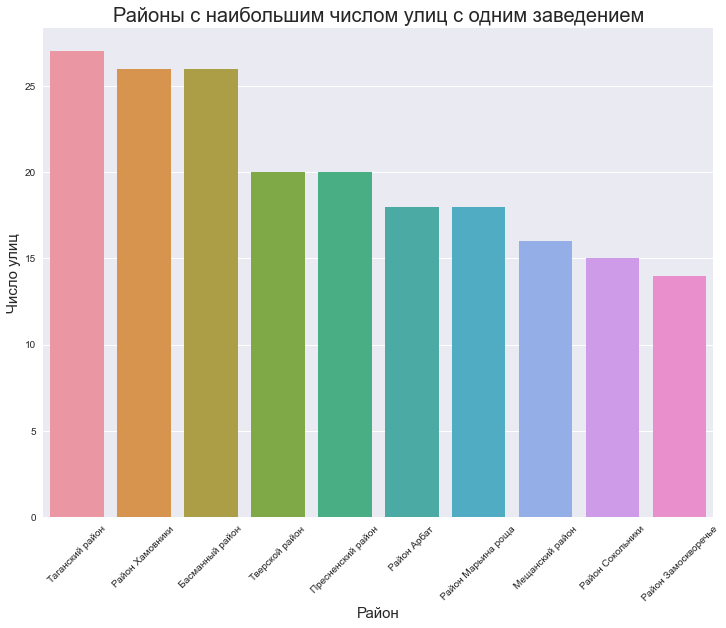

In [68]:
plt.figure(figsize=(12,9))
sns.barplot(x='area', y='street', data=only_one_district.head(10))
plt.title('Районы с наибольшим числом улиц с одним заведением', fontsize=20)
plt.xlabel('Район', fontsize=15)
plt.ylabel('Число улиц', fontsize=15)
plt.xticks(rotation=45);

В нашей базе есть почти 600 улиц, на которых находится по одному заведению. Если посмотреть на то, как эти улицы группируются по районам, то мы увидим, прежде всего, что на лидирующих позициях находятся районы в центре города - первые шесть, восьмое и десятое места в топ-10. Вероятно, это следует объяснять тем, что в центре много мелких улиц и много заведений, поскольку там много людей. Возможно, неплохой идеей для размещения нашего кафе будет одна из таких центральных улиц с небольшим числом заведений. Кроме того, сравнительно много 'одиночных' улиц в восточной части города (Марьина Роща, Сокольники, Лефортово и т.д.). 

[Наверх](#contents)

## 5. Общий вывод <a id='conclusion'></a>

1. Наибольшее число предприятий общественного питания в Москве - это кафе (40%), столовые (17%), рестораны (15%) и фастфуды (13%). Большая часть заведений относительно небольшие - половина московских заведений вмещает не более 40 человек, три четверти - не более 80, хотя есть и гораздо большие залы, рассчитанные на сотни человек, по преимуществу, столовые, банкетные залы и рестораны при гостиницах. Медианная вместимость сильно зависит от типа зведения: для столовых она превышает 100 человек, у ресторанов составляет 80 человек, бары, кафе и буфеты вмещают в среднем примерно по 30 человек, прочие не дотягивают до 10. 
2. Существенная часть рынка общественного питания (без малого 20%) представлена сетевыми заведениями, причем их распределение по типам отличается от общего по городу: 47% сетевых предприятий - это кафе, 27% - фастфуды, 18% - рестораны, тогда как остальные типы, в том числе столовые, составляют в сумме 8%. При этом наибольшая доля сетевых заведений - среди фастфудов (41%), кулинарий (28%), ресторан и кафе (примерно по 23-24%), тогда как сетевые столовые и буфеты практически неизвестны. Медианная вместимость разных типов сетевых заведений несколько больше, чем для тех же типов по всей выборке - сетевые рестораны в основном вмещают примерно по 90 человек, кафе - больше 40. 
3. В распределении заведений заметна определенная 'географическая' специфика. Больше всего заведений (как и сетевых заведений) располагается на длинных улицах - проспекте Мира, Профсоюзной, Ленинском проспекте и т.п. Несколько исключительный случай представляет Пресненская набережная, входящая в топ-10, по-видимому, из-за предприятий в Москва-Сити. В топ улиц по числу заведений входят также две относительно небольшие улицы в центре города - туристический Арбат и Земляной Вал (с ТЦ 'Атриум' и Курским вокзалом).
4. Улицы с большим количеством предприятий общественного питания сгруппированы в основном в южных (Чертаново, Нагатино), юго-западных (Гагаринский, Академический, Проспект Вернадского), а также в северных районах (прилегающих к проспекту Мира и Ленинградскому шоссе). С другой стороны, в Москве есть примерно 600 улиц с единственным заведением. Их число велико в центре (по числу таких районов лидируют Таганский район, Хамовники и Басманный район, за ними следуют Тверской и Пресненский районы, а также Арбат), кроме того, такие улицы часто (хотя и реже, чем в центре), попадаются в восточной части города.
5. В свете вышесказанного представляется оптимальным делать наше заведение кафе или небольшим рестораном с вместимостью в 40-80 человек. Этот сегмент рынка достаточно большой, что говорит о востребованности таких предприятий. Однако нужно иметь в виду, что в этом сегменте рынка особенно сильна конкуренция, в том числе и со стороны крупных сетей, так что расширение собственной сети кажется непростым, хотя и возможным. В качестве расположения по крайней мере первого ресторана рекомендуется выбрать одну из не самых 'популярных' улиц в центральных районах, однако для лучшего решения этого вопроса следует провести дополнительное исследование трафика потенциальных посетителей. 